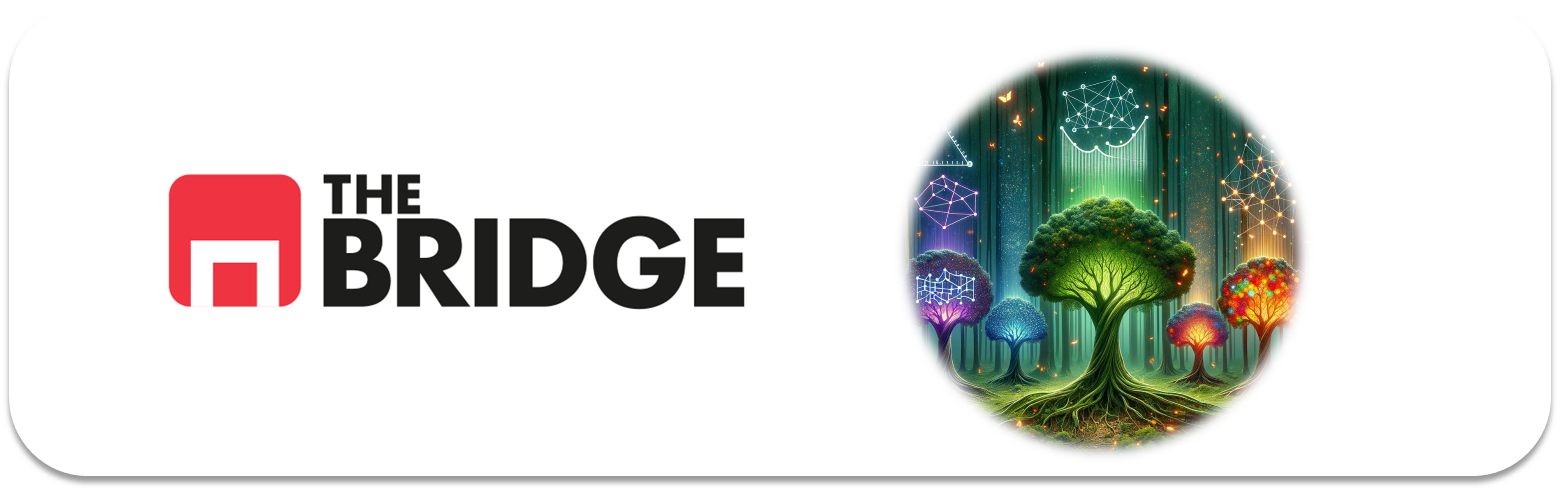

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [160]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
import numpy as np
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score, mean_absolute_percentage_error, classification_report, make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import pearsonr
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from matplotlib.colors import ListedColormap




# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Pintar
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

Datos del cliente bancario:

    Edad (numérico)

    Trabajo: tipo de trabajo (categorías: "admin.", "desconocido", "desempleado", "administración", "ama de casa", "empresario", "estudiante", "obrero", "autónomo", "jubilado", "técnico", "servicios")

    Estado civil: estado civil (categorías: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)

    Educación (categorías: "desconocido", "secundaria", "primaria", "universitaria")

    Default: ¿tiene crédito en mora? (binario: "sí", "no")

    Balance: saldo medio anual en euros (numérico)

    Vivienda: ¿tiene préstamo hipotecario? (binario: "sí", "no")

    Préstamo: ¿tiene préstamo personal? (binario: "sí", "no")

Relacionado con el último contacto de la campaña actual:

    Contacto: tipo de comunicación de contacto (categorías: "desconocido", "teléfono", "celular")

    Día: día del mes del último contacto (numérico)

    Mes: mes del año del último contacto (categorías: "enero", "febrero", "marzo", ..., "noviembre", "diciembre")

    Duración: duración del último contacto, en segundos (numérico)

Otros atributos:

    Campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)

    Pdays: número de días que han transcurrido desde que el cliente fue contactado por última vez en una campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente)

    Anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)

    Poutcome: resultado de la campaña de marketing anterior (categorías: "desconocido", "otro", "fracaso", "éxito")


In [24]:
df_bank=pd.read_excel(r"D:\Cursos\REPOSITORIOS\ONLINE_DS_THEBRIDGE_V\SPRINT_13\UNIT_1\PRACT_OBLIGATORIA\data\bank-full.xlsx")

In [3]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [25]:
df_bank.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [26]:
relacion=df_bank.groupby("poutcome")["balance"].unique()
relacion

poutcome
failure     [882, 3444, 0, 3132, 1005, 899, 1243, 1631, 119, 58, 6203, 105, 1533, 228, 1623, 1484, 198, 1477, 401, 3324, 1865, 633, 2749, 209, 246, 1415, 5766, 101, 5057, 1265, 8106, 1364, 46, 5423, 8332, 689, 4344, 472, 252, 4425, -36, 1730, 202, 313, 419, 1048, 112, 563, 1797, 3440, 373, 2020, 24, 425, 80, 634, 830, 2719, 248, 12061, -15, 4, 3111, 1451, 557, 600, 350, 1818, 20, -954, 230, 505, 821, 275, 1049, 1414, 11971, 271, -478, 3795, 653, 1255, -403, 2636, 1029, 1502, 426, 237, 8, 1043, 1027, 724, 219, 2106, 2767, 1269, 1150, 5115, 1092, 121, ...]
other      [-247, 2415, 1324, 172, 1770, 494, 1701, 1718, 35, 500, 2370, 514, 1270, 4826, 0, 677, 899, -259, 3552, 3843, 109, 5, 1158, 4958, 204, 3275, 9339, 559, 283, 154, 428, 661, 1494, 26, 1041, 1927, 5862, 694, 179, 1441, 484, 1785, 2076, 3046, 1482, 1356, 3729, -1882, 2169, 521, 932, 728, 1095, 22, 826, 1937, -184, 202, 1295, 66, 839, 481, 4278, 7118, -366, 4728, 961, 50, 649, 86, 804, 4591, 1570, -26, 1429, 9347, 149, 3

In [27]:
print(relacion.success.sum())
print(relacion.failure.sum())
print(relacion.other.sum())
print(relacion.unknown.sum())

2181360
5419356
2520422
29186154


In [28]:
relacion2=df_bank.groupby("poutcome")["education"].value_counts()
relacion2

poutcome  education
failure   secondary     2589
          tertiary      1492
          primary        643
          unknown        177
other     secondary      987
          tertiary       544
          primary        244
          unknown         65
success   secondary      675
          tertiary       622
          primary        133
          unknown         81
unknown   secondary    18951
          tertiary     10643
          primary       5831
          unknown       1534
Name: count, dtype: int64

In [29]:
relacion3=df_bank.groupby("poutcome")["housing"].value_counts()
relacion3

poutcome  housing
failure   yes         3470
          no          1431
other     yes         1199
          no           641
success   no          1040
          yes          471
unknown   yes        19990
          no         16969
Name: count, dtype: int64

In [30]:
relacion4=df_bank.groupby("poutcome")["duration"].unique()
relacion4

poutcome
failure                    [39, 144, 140, 449, 175, 114, 86, 81, 200, 79, 58, 303, 324, 80, 161, 297, 120, 75, 396, 96, 44, 219, 155, 302, 38, 130, 270, 483, 68, 348, 70, 118, 125, 90, 508, 93, 164, 110, 214, 229, 138, 74, 147, 190, 103, 89, 651, 42, 186, 71, 1081, 504, 166, 124, 174, 62, 128, 240, 65, 139, 150, 223, 111, 157, 158, 116, 113, 99, 189, 48, 159, 69, 836, 171, 224, 295, 101, 422, 78, 609, 148, 87, 227, 193, 151, 178, 117, 340, 127, 333, 57, 188, 273, 204, 499, 374, 353, 107, 1210, 176, ...]
other                   [519, 73, 119, 21, 26, 146, 381, 74, 38, 257, 56, 573, 80, 102, 809, 619, 61, 732, 690, 70, 124, 118, 204, 599, 64, 295, 121, 52, 47, 346, 231, 116, 411, 596, 419, 586, 288, 352, 91, 432, 93, 51, 178, 84, 177, 264, 597, 244, 716, 17, 133, 135, 148, 286, 171, 238, 195, 185, 825, 139, 110, 630, 164, 43, 210, 313, 114, 589, 224, 155, 94, 89, 201, 1015, 138, 424, 69, 169, 113, 265, 1548, 360, 623, 1065, 382, 783, 130, 287, 209, 611, 380, 168, 11, 255, 854, 1

In [31]:
print(relacion4.success.sum())
print(relacion4.failure.sum())
print(relacion4.other.sum())
print(relacion4.unknown.sum())

254862
401606
250588
1276448


In [32]:
relacion5=df_bank.groupby("poutcome")["previous"].unique()
relacion5

poutcome
failure    [3, 4, 1, 2, 6, 10, 12, 9, 11, 7, 5, 8, 14, 15, 26, 25, 27, 16, 13, 38, 29, 51, 23, 17, 22, 24, 19, 30, 21, 18, 28, 32, 20, 55, 35]
other         [1, 4, 2, 11, 16, 5, 7, 18, 21, 8, 9, 3, 6, 12, 10, 37, 13, 15, 20, 17, 23, 24, 25, 14, 275, 29, 27, 19, 30, 22, 58, 26, 40, 41]
success                                                                        [2, 3, 1, 4, 10, 7, 8, 6, 5, 12, 9, 13, 11, 21, 15, 28, 22, 14]
unknown                                                                                                                        [0, 1, 5, 2, 7]
Name: previous, dtype: object

In [33]:
print(relacion5.success.sum())
print(relacion5.failure.sum())
print(relacion5.other.sum())
print(relacion5.unknown.sum())

191
676
888
15


In [34]:
relacion6=df_bank.groupby("poutcome")["pdays"].unique()
relacion6

poutcome
failure      [151, 91, 143, 176, 174, 170, 195, 165, 129, 188, 196, 172, 118, 167, 119, 171, 132, 131, 123, 186, 111, 116, 173, 166, 164, 110, 115, 152, 96, 103, 150, 175, 104, 193, 181, 154, 145, 138, 126, 180, 109, 101, 117, 168, 97, 182, 127, 130, 194, 125, 105, 102, 179, 183, 155, 112, 124, 187, 190, 162, 159, 113, 134, 169, 189, 8, 120, 137, 144, 191, 184, 177, 99, 133, 93, 92, 10, 100, 156, 106, 153, 198, 146, 128, 160, 107, 90, 147, 197, 136, 139, 185, 122, 178, 157, 149, 135, 30, 114, 192, ...]
other      [166, 86, 89, 140, 101, 104, 117, 167, 115, 178, 103, 188, 165, 185, 181, 171, 145, 123, 150, 129, 131, 109, 158, 186, 168, 172, 193, 179, 96, 173, 182, 127, 120, 137, 110, 113, 154, 183, 174, 134, 116, 151, 152, 132, 126, 112, 187, 111, 180, 133, 97, 170, 175, 198, 190, 189, 153, 195, 184, 105, 100, 118, 122, 156, 196, 177, 125, 98, 95, 163, 155, 92, 99, 130, 128, 119, 192, 94, 106, 176, 108, 141, 253, 244, 204, 258, 223, 250, 266, 240, 268, 246, 239, 164, 245, 237, 

In [35]:
print(relacion6.success.sum())
print(relacion6.failure.sum())
print(relacion6.other.sum())
print(relacion6.unknown.sum())

73089
138003
96496
1397


VOY A ESTUDIAR EL PROBLEMA DE POSOBLES CLIENTES QUE CONTRARAN LA NUEVA CAMPAÑA, EN RELACIÓN AL NUMERO  DE CONTACTO PREVIOS A LA ULTIMA CAMPAÑA PARA UN CLIENTE, YA QUE LA SUMA DE LOS QUE CONTRARON EN LA CATEGORIA DE OTROS Y SATAISFACTORIOS  SUMAN MAS CASOS QUE LOS DESCONOCIDOS Y FRACASADOS. la variable Previous, aunque tb seria interesante pdays


Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

In [36]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [20]:
df_bank.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [21]:
df_bank.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

In [22]:
df_bank.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [23]:
df_bank.default.unique()# LA CAMBIO A BINARIO 0 Y 1 

array(['no', 'yes'], dtype=object)

In [24]:
df_bank.housing.unique()#la cambio a binaria 0 y 1

array(['yes', 'no'], dtype=object)

In [21]:
df_bank.loan.unique()

array(['no', 'yes'], dtype=object)

In [22]:
df_bank.contact.unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [25]:
df_bank.campaign.unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44],
      dtype=int64)

In [26]:
df_bank.pdays.unique()

array([ -1, 151, 166,  91,  86, 143, 147,  89, 140, 176, 101, 174, 170,
       167, 195, 165, 129, 188, 196, 172, 118, 119, 104, 171, 117, 164,
       132, 131, 123, 159, 186, 111, 115, 116, 173, 178, 110, 152,  96,
       103, 150, 175, 193, 181, 185, 154, 145, 138, 126, 180, 109, 158,
       168,  97, 182, 127, 130, 194, 125, 105, 102,  26, 179,  28, 183,
       155, 112, 120, 137, 124, 187, 190, 113, 162, 134, 169, 189,   8,
       144, 191, 184, 177,   5,  99, 133,  93,  92,  10, 100, 156, 198,
       106, 153, 146, 128,   7, 121, 160, 107,  90,  27, 197, 136, 139,
       122, 157, 149, 135,  30, 114,  98, 192, 163,  34,  95, 141,  31,
       199,  94, 108,  29, 268, 247, 253, 226, 244, 239, 245, 204, 231,
       238, 258, 230, 254, 265,  71, 223, 246, 250, 266, 240, 205, 261,
       259, 241, 260, 234, 251, 225, 161, 237, 262, 248, 255, 220, 227,
       206, 224, 249, 235, 228, 263,   2, 270, 232, 252, 207, 200, 269,
       233, 256, 273, 272, 242, 264, 208, 214, 222, 271, 203, 22

In [37]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [38]:
# convertimos las variables default, housing, loan e y en numérica y la eliminamos:
df_bank["default"] = df_bank["default"].apply(lambda value: 1 if value == "yes" else 0)
df_bank["housing"] = df_bank["housing"].apply(lambda value: 1 if value == "yes" else 0)
df_bank["loan"] = df_bank["loan"].apply(lambda value: 1 if value == "yes" else 0)
df_bank["y"] = df_bank["y"].apply(lambda value: 1 if value == "yes" else 0)

df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0


In [39]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  int64 
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  int64 
 7   loan       45211 non-null  int64 
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(11), object(6)
memory usage: 5.9+ MB


In [40]:
df_bank.shape

(45211, 17)

CODIFICO MEDIANTE ONE HOT ENCODING LAS TIPO OBJECTS

In [41]:
df_bank_encode= pd.get_dummies(df_bank, dtype= int, columns=["job", "marital", "education","contact","month","poutcome"])

In [42]:
df_bank_encode

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,456,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,1127,5,184,3,...,0,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,508,4,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [43]:
df_bank_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  int64
 11  job_admin.           45211 non-null  int32
 12  job_blue-collar      45211 non-null  int32
 13  job_entrepreneur     45211 non-null  int32
 14  job_housemaid        45211 non-null  int32
 15  job_management       45211 non-null  int32
 16  job_retired          4

In [44]:
df_bank_encode.shape

(45211, 49)

SPLIT

In [45]:
df_bank_encode.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [46]:
feature_columns = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
                   'campaign', 'pdays', 'job_admin.', 'job_blue-collar',
                   'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
                   'job_self-employed', 'job_services', 'job_student', 'job_technician',
                   'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
                   'marital_single', 'education_primary', 'education_secondary',
                   'education_tertiary', 'education_unknown', 'contact_cellular',
                   'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
                   'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
                   'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
                   'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']

In [47]:
X = df_bank_encode[feature_columns]

y=df_bank_encode["previous"]

In [69]:
train_X,test_X, train_y, test_y= train_test_split( X, y, test_size=0.2 , random_state=42)

print("train_X shape después de la división:", train_X.shape)
print("train_y shape después de la división:", train_y.shape)

train_X shape después de la división: (36168, 47)
train_y shape después de la división: (36168,)


In [70]:
train_X.shape

(36168, 47)

In [71]:
train_y.shape

(36168,)

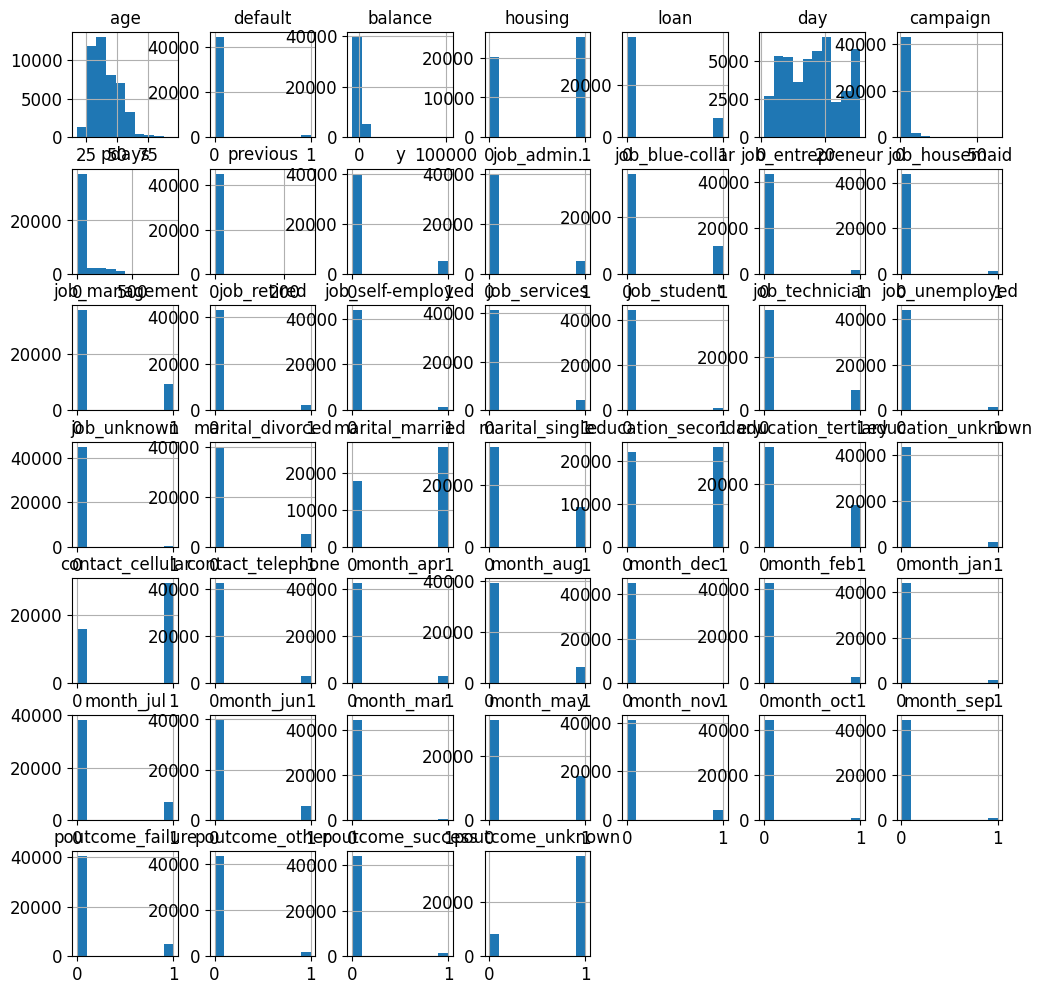

In [73]:
df_bank_encode.hist(figsize=(12,12));

estan bien las graficas, seguimos con las correlaciones

In [74]:
correla_abs= np.abs(df_bank_encode.corr(numeric_only=True)["previous"].sort_values(ascending = False))
correla_abs

previous               1.000000
pdays                  0.454820
poutcome_failure       0.350627
poutcome_other         0.306615
poutcome_success       0.201424
contact_cellular       0.131717
y                      0.093236
month_feb              0.065243
month_sep              0.064990
month_apr              0.053985
month_oct              0.053934
month_jan              0.047004
month_nov              0.037868
housing                0.037076
month_dec              0.036628
contact_telephone      0.028097
month_mar              0.027273
job_student            0.023556
education_tertiary     0.022888
job_management         0.019579
marital_single         0.017006
balance                0.016674
job_admin.             0.014245
job_retired            0.005818
month_may              0.001341
age                    0.001288
job_technician         0.001123
job_self-employed      0.002371
marital_divorced       0.004534
education_secondary    0.005603
job_entrepreneur       0.008181
educatio

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


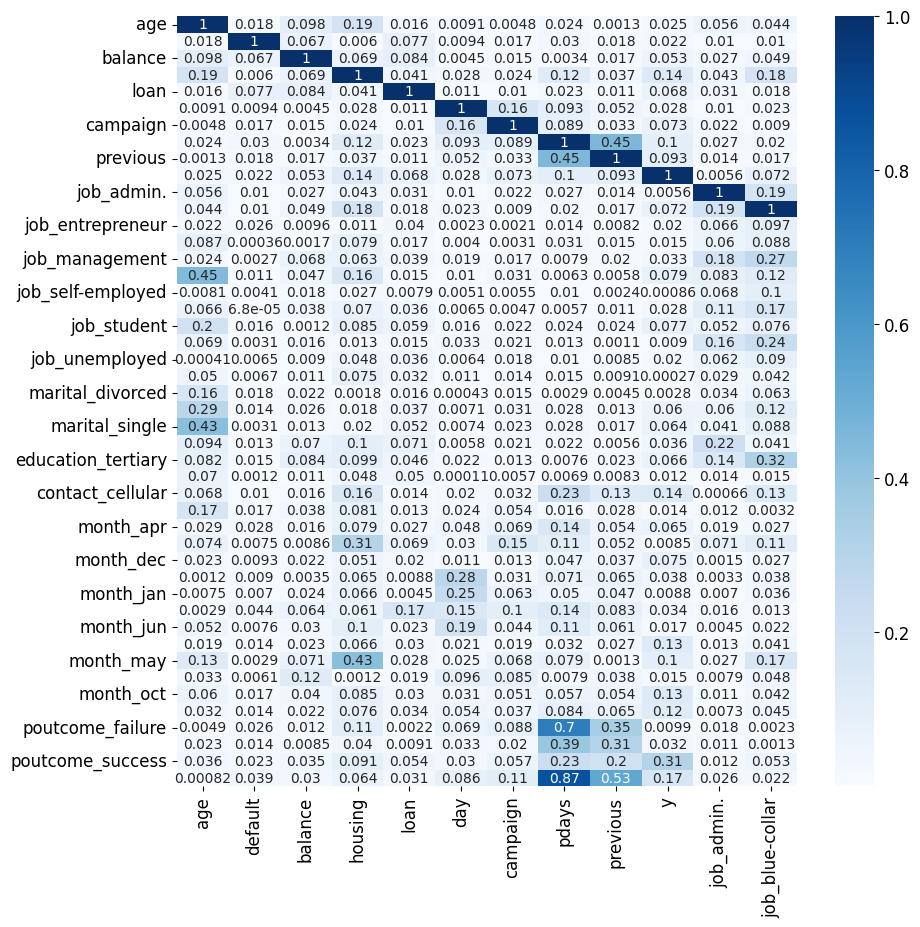

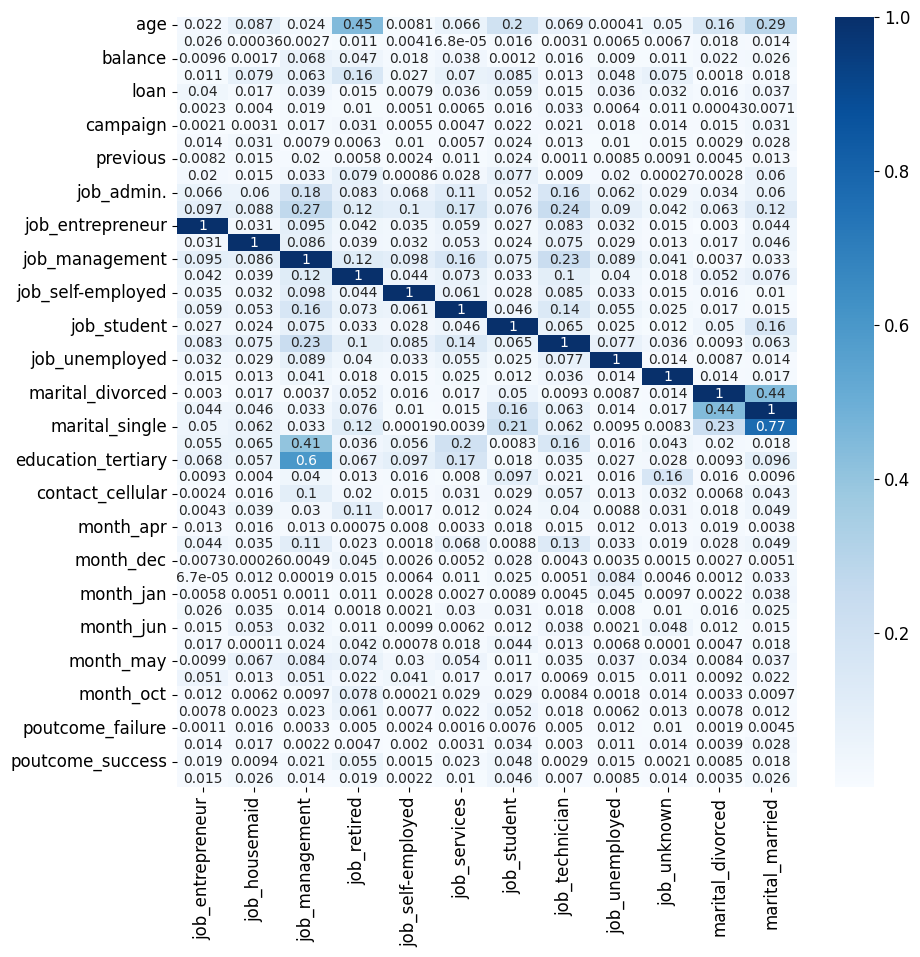

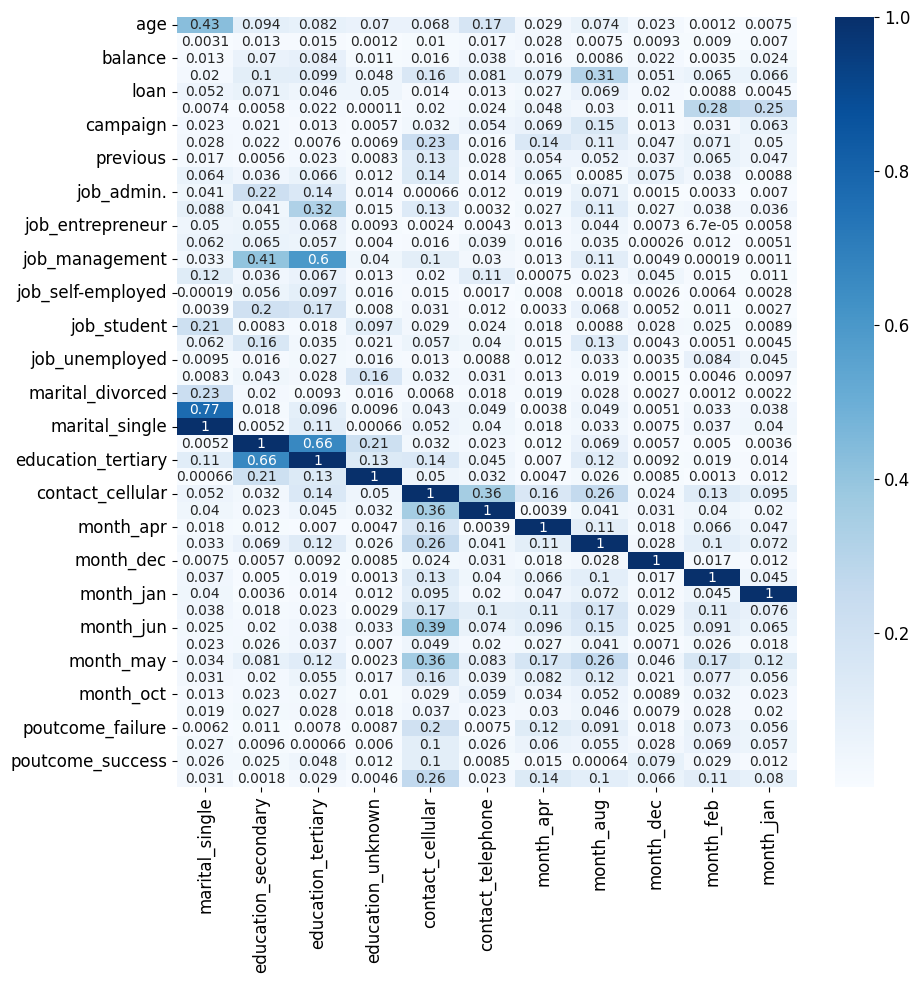

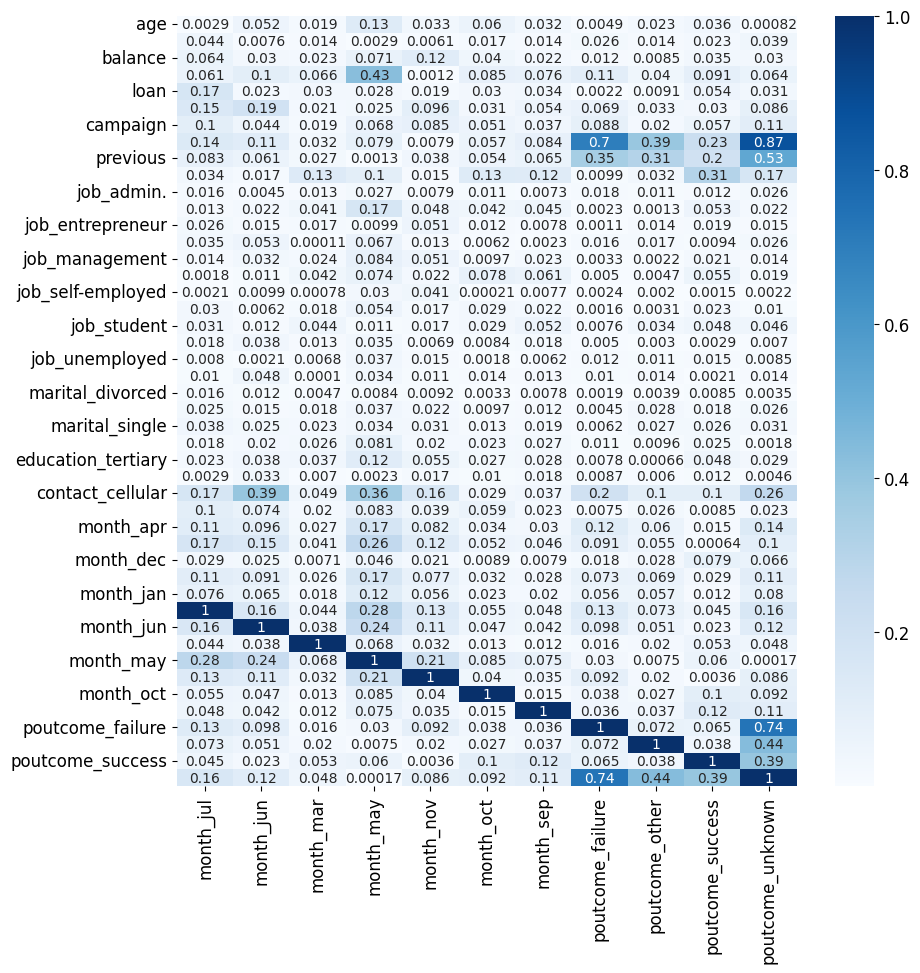

In [75]:
# Obtenemos la matriz de correlaciones
corr = np.abs(df_bank_encode.corr(numeric_only=True))

# Dividimos la matriz de correlaciones en cuatro partes
corr_split = np.array_split(corr, 4, axis=1)

# Pintamos cada parte de la matriz de correlaciones
for i in range(4):
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_split[i], cmap="Blues", annot=True)
    plt.show();

debido a que tiene valores altos muy pegados a la variable target ,siendo estos valores repetidos, eliminamos las columnas education_primary, contact_unknown y duration

In [56]:
df_bank_encode.drop(columns={"education_primary", "contact_unknown", "duration"}, inplace=True)

In [76]:
df_bank_encode.shape

(45211, 46)

In [77]:
df_bank_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   campaign             45211 non-null  int64
 7   pdays                45211 non-null  int64
 8   previous             45211 non-null  int64
 9   y                    45211 non-null  int64
 10  job_admin.           45211 non-null  int32
 11  job_blue-collar      45211 non-null  int32
 12  job_entrepreneur     45211 non-null  int32
 13  job_housemaid        45211 non-null  int32
 14  job_management       45211 non-null  int32
 15  job_retired          45211 non-null  int32
 16  job_self-employed    4

FUNCION PARA PINTAR PLOTS DEL TEAM CHALLEGE

In [78]:
def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Crea un conjunto de pair plots para visualizar las correlaciones entre las columnas numéricas del DataFrame.

    Args:
        df: El DataFrame del que se quiere visualizar las correlaciones.
        target_col: El nombre de la columna objetivo.
        umbral_corr= numbral maximo establecido de correlacion con la target
        pvalue: El valor de p-valor.

    Returns:
        None
    """

    columnas_para_pintar = []
    columnas_umbral_mayor = []

    #iteramos por la columnas
    for col in columns:
        #si en la iteracion de las columnas del DF y siempre que...
        # se comprube si son numéricas(true) o no son numéricas(false)
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # usando el indice de correlación de Pearson y el p-valor(funcion pearsonr)
            # calculamos dichos parametros para target y resto de columnas
            corr, pv = pearsonr(df[col], df[target_col])
            if abs(corr) > umbral_corr:
                columnas_umbral_mayor.append(col)
                if pvalue is None or pv < pvalue:
                    columnas_para_pintar.append(col)

    # Número máximo de gráficas por grupo
    max_graficas_por_grupo = 6

    # Dividir en grupos según el número máximo de gráficas
    len(columnas_para_pintar) // max_graficas_por_grupo
    # En un alista de comprension, iteramos en rango desde 0 hasta el numero de columnas a pintar, por cada grupo maximo establecido
    # creando graficas con columnas maxi de i+ grupo max establecido ( ejem: '0 hasta 0+6)
    columnas = [columnas_para_pintar[i:i+max_graficas_por_grupo] for i in range(0, len(columnas_para_pintar), max_graficas_por_grupo)]

    # iteramos por i y por valor 'umbral_corr' establecido a cada grupo en cada iteración,  creeando pair plots para cada grupo,
    for i, grupo in enumerate(columnas):
        sns.pairplot(df, vars=grupo, hue=target_col)
        plt.suptitle(f"Group {i}", y=1.02)# creo nombres de grupo un poco por encima de y, para que no se superponga con la gráfica
        plt.show()
    
    return "Las columnas con un mayor umbral_corr al establecido son", columnas_umbral_mayor

In [79]:
df_bank_encode.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign',
       'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

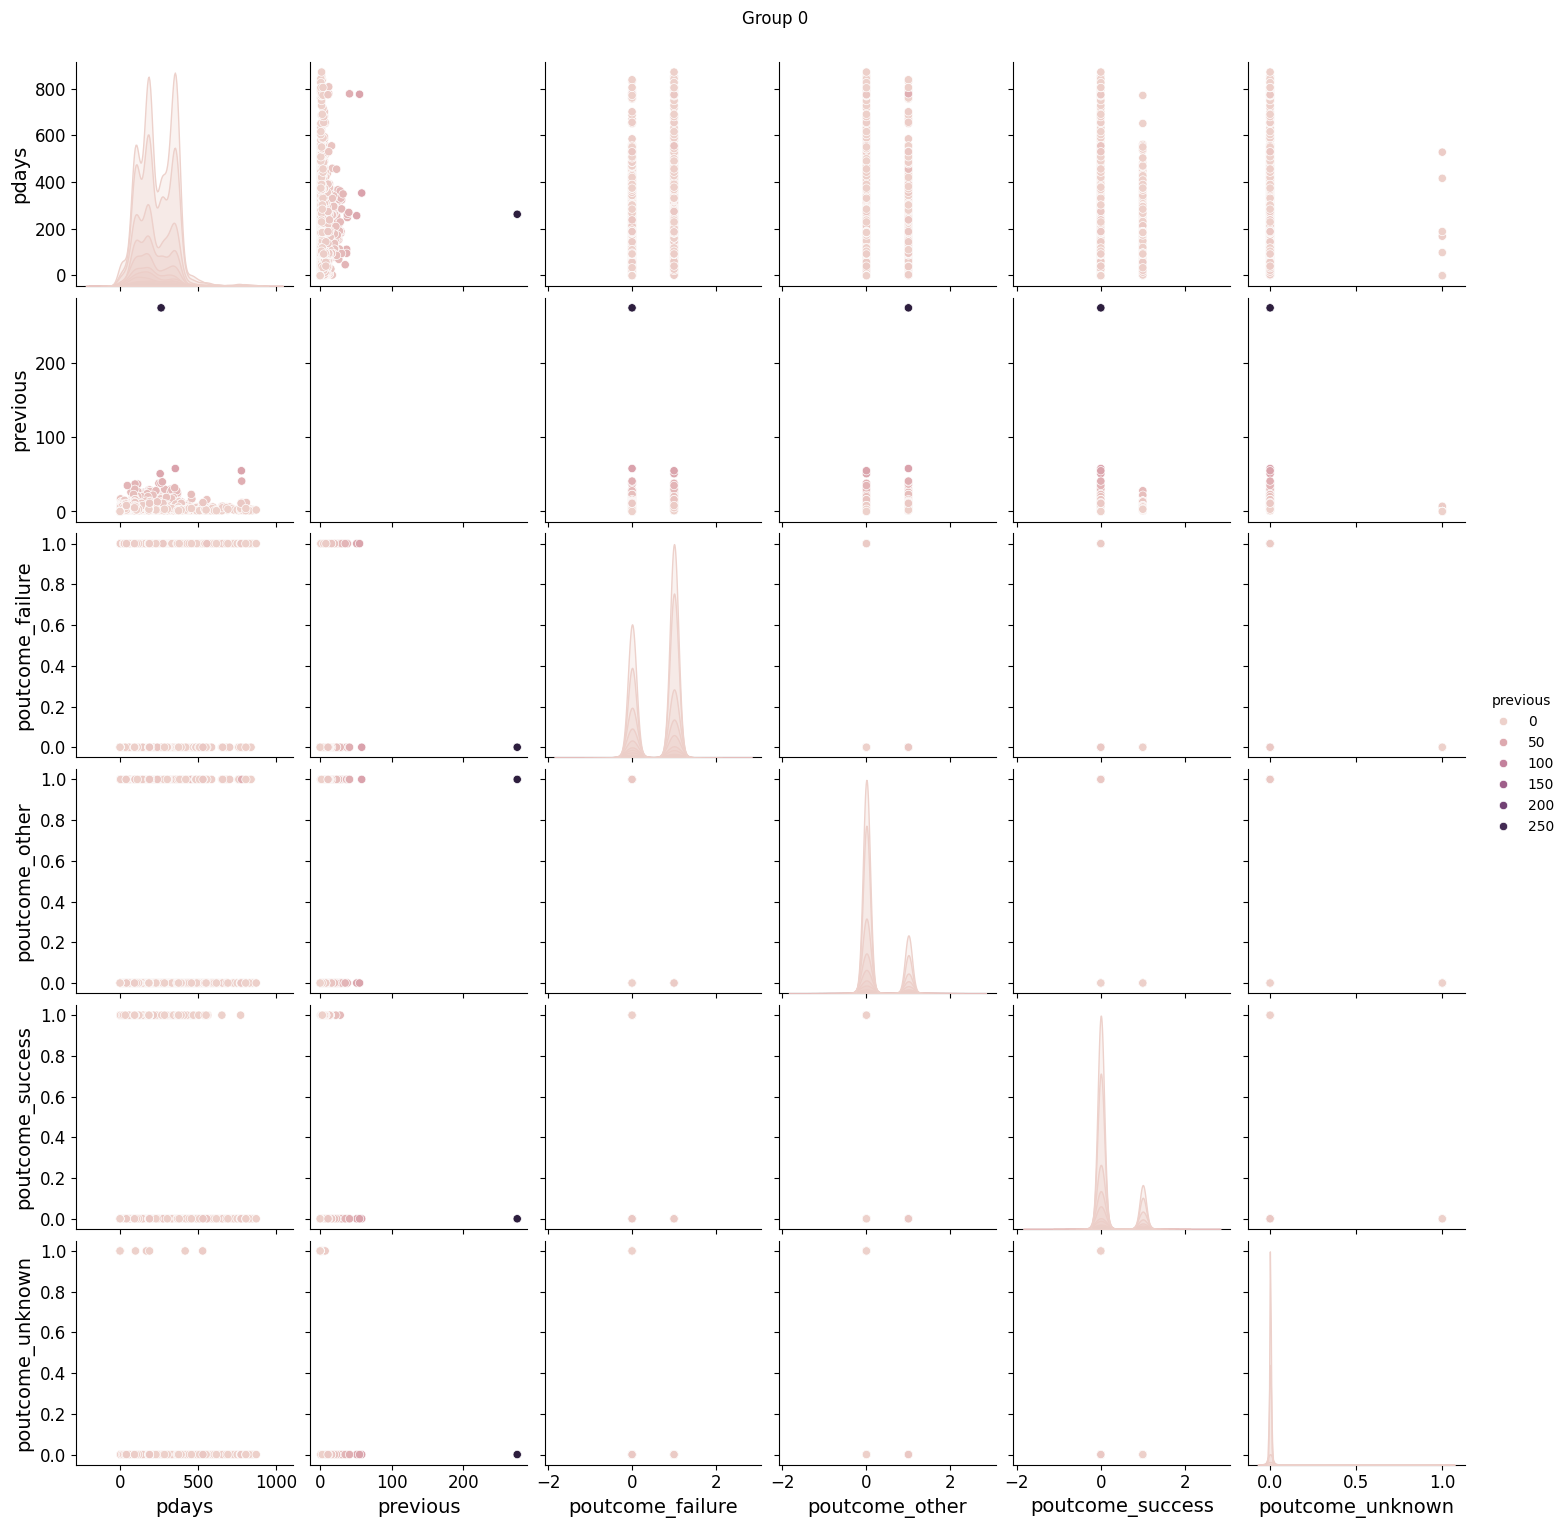

In [80]:
plot_features_num_regression(df_bank_encode, target_col="previous", columns=['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign',
       'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], umbral_corr=0.2, pvalue=None);

HACEMOS LA VALIDACION CRUZADA PARA ENCONTRAR LOS MEJORES VALORES PARA NUESTRO  NUESTRO ARBOL CLASIFICATORIO

In [83]:
# CREAMOS VALORES  a probar
max_depths = [None, 2, 4,6,8, 10]
min_samples_splits = [10, 100, 500, 1000, 5000,10000]

# aplicamos modelo
scores = []
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        scores.append(cross_val_score(clf, train_X, train_y, cv=5))

# resultados
for max_depth, min_samples_split, scores_cv in zip(max_depths, min_samples_splits, scores):
    print("max_depth:", max_depth, "min_samples_split:", min_samples_split, "scores_cv:", scores_cv)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.

max_depth: None min_samples_split: 10 scores_cv: [0.8636992  0.85996682 0.85955212 0.86409512 0.86450989]
max_depth: 2 min_samples_split: 100 scores_cv: [0.87268455 0.87309925 0.87309925 0.87142265 0.87515554]
max_depth: 4 min_samples_split: 500 scores_cv: [0.87683163 0.8771081  0.87614045 0.8780589  0.87916494]
max_depth: 6 min_samples_split: 1000 scores_cv: [0.87655516 0.87779928 0.87766105 0.87722937 0.87792064]
max_depth: 8 min_samples_split: 5000 scores_cv: [0.8786287  0.87849046 0.87849046 0.87861192 0.87861192]
max_depth: 10 min_samples_split: 10000 scores_cv: [0.8786287  0.87849046 0.87849046 0.87861192 0.87861192]


In [84]:

# Crear un clasificador de árbol de decisión
tree_clf = DecisionTreeClassifier()

In [85]:
#creamos el modelo

tree_clf = DecisionTreeClassifier(max_depth=8, min_samples_split=5000, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=8, min_samples_split=5000, random_state=42)

In [99]:

tree_clf.fit(train_X, train_y)
y_pred = tree_clf.predict(test_X)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7398
           1       0.34      1.00      0.50       552
           2       0.00      0.00      0.00       426
           3       0.00      0.00      0.00       230
           4       0.00      0.00      0.00       142
           5       0.00      0.00      0.00        97
           6       0.00      0.00      0.00        51
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         3
          17       0.00    

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [86]:
tree_clf.predict_proba(X)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.47202442e-01, 2.29908444e-01, ...,
        5.08646999e-04, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.04438964e-01, 2.69112207e-01, ...,
        0.00000000e+00, 3.08261406e-04, 3.08261406e-04]])

In [87]:
tree_clf.predict(X)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

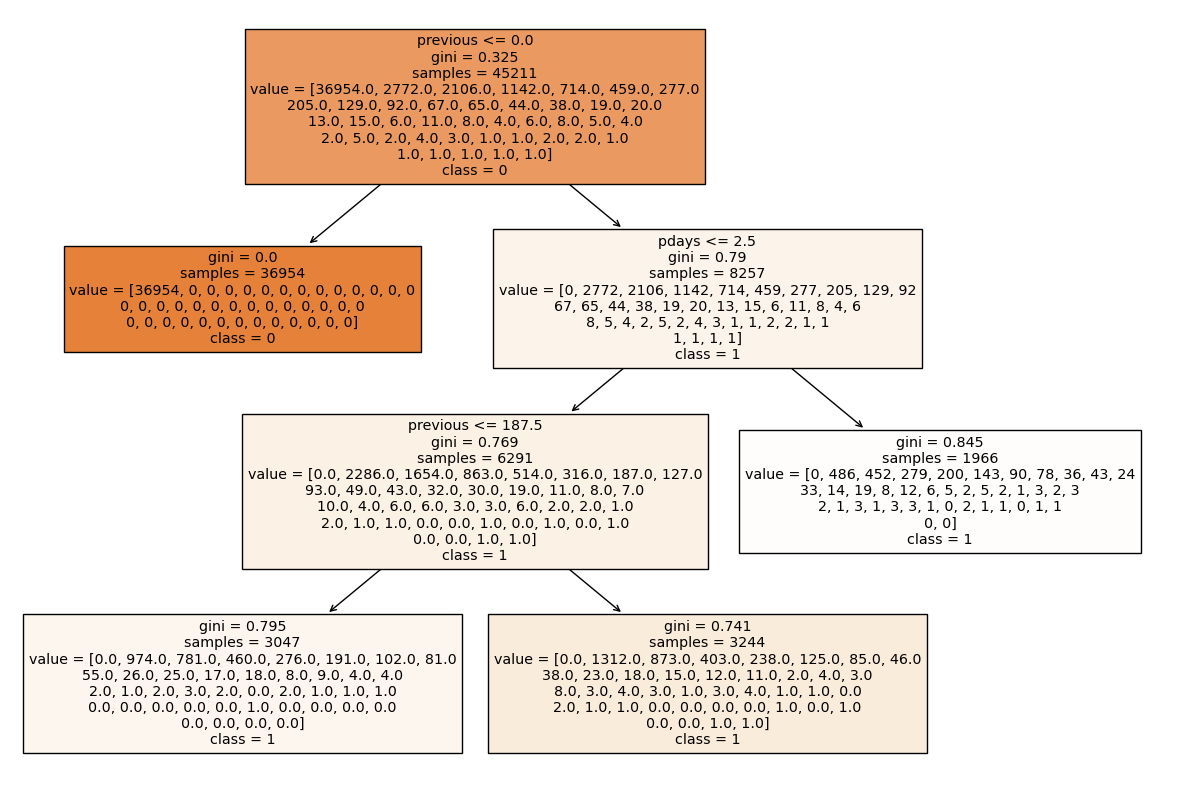

In [88]:
# Visualizar el árbol
plt.figure(figsize=(15, 10))
plot_tree(tree_clf, filled=True, feature_names=df_bank_encode.columns, class_names=[str(i) for i in tree_clf.classes_])
plt.show()


In [89]:
print(train_X.shape)
print(train_y.shape)


(36168, 47)
(36168,)


# usamos el la optimizacion bayesiana para modelo

In [149]:


def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, train_X, train_y, 
                           cv=5, scoring= scoring).mean() 
# Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.01,0.02),
    'l1_ratio': hp.uniform('l1_ratio', 0.99,1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1000, trials=trials)


100%|██████████| 1000/1000 [3:25:10<00:00, 12.31s/trial, best loss: -0.783843862624189]  


el modelo ha realziado las iteraciones un toyal de 1000 iteraciones de optimizacion consistentes en actualziacion de parametros segun los datos ( alpha 0.01 a 0.02 y l1-ratio: 0.99 a 1) a 12.31 trial/sg y la perdida minima obtenida durante la optimizaciones de -0.78, es decirt, el 78% de variavilidad de la variable target, por lo que es un resultado bueno

In [100]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1],
    'l1_ratio': np.arange(0,1,0.01)
}


In [101]:
elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=1000, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(train_X, train_y)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 400 is smaller than n_iter=1000. Running 400 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': [1e-10, 0.0001, 0.01, 1],
                                        'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [153]:
# Mejores parámetros del modelo
random_search.best_params_

{'l1_ratio': 0.99, 'alpha': 0.01}

In [154]:
# Mejor score (R2)
random_search.best_score_**2

2165.6389357087173

In [155]:
random_search.best_estimator_.coef_

array([-6.01357618e-02,  1.88239295e+00, -1.51736210e-04,  5.36885441e+00,
       -6.38358834e-01, -1.07902984e-01,  7.21158930e-02, -4.52603130e-01,
        2.37197732e-01,  2.81300321e+00,  1.63650988e-01, -2.09362653e+00,
        0.00000000e+00, -3.52164513e+00, -7.09940555e-01,  1.12227381e+00,
       -8.34941579e+00, -1.43614263e+00,  1.33775438e+00, -0.00000000e+00,
        1.90622846e+00, -6.94282318e-01, -0.00000000e+00, -9.94542963e-01,
       -3.91208124e+00, -7.62580670e-01,  1.42025918e+01,  1.48527861e+01,
        7.48335443e+00, -0.00000000e+00,  0.00000000e+00, -8.90000063e+00,
       -8.96032391e+00,  1.98787219e+00,  9.22332340e+00, -0.00000000e+00,
        1.66966576e+01, -2.09095831e+01, -4.82658535e+00,  3.97079375e+00,
        7.26417888e+01,  6.10426434e+01, -0.00000000e+00, -1.67408501e+02])

In [156]:
random_search.best_estimator_.score(test_X, test_y) # nos da el R2

0.7911775618406695

In [110]:
model = ElasticNet(alpha=0.0001, l1_ratio=0.01)
model.fit(train_X, train_y)
print(model.score(train_X,train_y))
print("RMSE_train", mean_squared_error(train_y, model.predict(train_X), squared = False))
print(model.score(test_X, test_y))
print("RMSE_test", mean_squared_error(test_y, model.predict(test_X), squared = False))

0.2768652225049729
RMSE_train 2.015925128249312
0.38011365889998916
RMSE_test 1.5842933075798828


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.110e+04, tolerance: 2.033e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


PROBEMOS UNA REGRESION LINEAL SIN OPTIMIZAR A VER QUE RESULTADOS

In [112]:
model = LinearRegression()
model.fit(train_X, train_y)
print(model.score(train_X,train_y))
print("RMSE", mean_squared_error(train_y, model.predict(train_X), squared = False))
print(model.score(test_X, test_y))
print("RMSE", mean_squared_error(test_y, model.predict(test_X), squared = False))

0.27686560903925495
RMSE 2.0159245894671227
0.38009474180142555
RMSE 1.5843174813695107


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


hay un buen ajuste de datos en el modelo elasticNet, aqunye el modelo linarregresion no da malos valores

Una vez entrenado el arbol y haberlo ajustado y optimizado, hallamos el atributo feature_importance_ dando un resultado de un 99% de importancia de la variable pdays, siendo junto a previous las que mas importnacia les di al principio. Este parametro indica lo bien que se pueden dividir los datos en los nodos hijos, siendo los valores mas altos los que contribuyen mas a dividir los datos en nodos hijos

In [119]:
tree_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00308752, 0.99691248, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [120]:
pd.DataFrame({'features':X.columns,
              'importance':tree_clf.feature_importances_}).sort_values('importance',
                                                                  ascending=False)

,features,importance
8,pdays,0.996912
7,campaign,0.003088
0,age,0.000000
36,month_jul,0.000000
27,education_unknown,0.000000
28,contact_cellular,0.000000
29,contact_telephone,0.000000
30,contact_unknown,0.000000
31,month_apr,0.000000
32,month_aug,0.000000


VOY PROBAR EL MODELO CON  VARIABLE PDAYS COMO TARGET

In [126]:
feature_columns = ['age', 'default', 'balance', 'housing', 'loan', 'day',
                   'campaign', "previous", 'job_admin.', 'job_blue-collar',
                   'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
                   'job_self-employed', 'job_services', 'job_student', 'job_technician',
                   'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
                   'marital_single', 'education_secondary',
                   'education_tertiary', 'education_unknown', 'contact_cellular',
                   'contact_telephone', 'month_apr', 'month_aug',
                   'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
                   'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
                   'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']

In [129]:
X = df_bank_encode[feature_columns]

y=df_bank_encode['pdays']

In [128]:
train_X,test_X, train_y, test_y= train_test_split( X, y, test_size=0.2 , random_state=42)

print("train_X shape después de la división:", train_X.shape)
print("train_y shape después de la división:", train_y.shape)

train_X shape después de la división: (36168, 44)
train_y shape después de la división: (36168,)


In [131]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1],
    'l1_ratio': np.arange(0.99,5,10)
}


In [132]:
elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=1000, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(train_X, train_y)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=1000. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=ElasticNet(), n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 0.5, 1],
                                        'l1_ratio': array([0.99])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [133]:
random_search.best_params_

{'l1_ratio': 0.99, 'alpha': 0.01}

In [134]:
random_search.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.99)

In [137]:
random_search.best_score_**2

2165.6389357087173

In [139]:
random_search.best_estimator_.coef_

array([-6.01357618e-02,  1.88239295e+00, -1.51736210e-04,  5.36885441e+00,
       -6.38358834e-01, -1.07902984e-01,  7.21158930e-02, -4.52603130e-01,
        2.37197732e-01,  2.81300321e+00,  1.63650988e-01, -2.09362653e+00,
        0.00000000e+00, -3.52164513e+00, -7.09940555e-01,  1.12227381e+00,
       -8.34941579e+00, -1.43614263e+00,  1.33775438e+00, -0.00000000e+00,
        1.90622846e+00, -6.94282318e-01, -0.00000000e+00, -9.94542963e-01,
       -3.91208124e+00, -7.62580670e-01,  1.42025918e+01,  1.48527861e+01,
        7.48335443e+00, -0.00000000e+00,  0.00000000e+00, -8.90000063e+00,
       -8.96032391e+00,  1.98787219e+00,  9.22332340e+00, -0.00000000e+00,
        1.66966576e+01, -2.09095831e+01, -4.82658535e+00,  3.97079375e+00,
        7.26417888e+01,  6.10426434e+01, -0.00000000e+00, -1.67408501e+02])

In [138]:
random_search.best_estimator_.score(test_X, test_y) # nos da el R2

0.7911775618406695

In [150]:
#OPTIMIZAMOS BAYESIANA


def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, train_X, train_y, 
                           cv=5, scoring= scoring).mean() 
# Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.01, 0.1),
    'l1_ratio': hp.uniform('l1_ratio', 0.9, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)


100%|██████████| 100/100 [08:48<00:00,  5.29s/trial, best loss: -0.783908540112285]


el modelo ha realziado un total de 100 iteraciones, es decir 900 menos que el anterior,  de optimizacion consistentes en actualziacion de parametros segun los datos ( alpha 0.01 a 0.02 y l1-ratio: 0.99 a 1) a 5.29 trial/sg y la perdida minima obtenida durante la optimizaciones de -0.78, es decir, el 78% de variavilidad de la variable target, por lo que es un resultado bueno

In [166]:
#funcion para que te diga los mejores hiperparametros para ajustar la generalziacion de un modelo de regresion lienal

# Definir el modelo
from sklearn.metrics import classification_report
model = ElasticNet()

# Definir los parámetros a buscar
params = {
    'alpha': [0.01,0.1, 0.5, 1.0, 2.0, 5.0],  # Valores de alpha para la regularización
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Proporción entre L1 y L2 en regresión elástica
}

# Definir la métrica a optimizar (en este caso, MAE)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(model, params, scoring=scorer, cv=5)
grid_search.fit(train_X, train_y)

# Mostrar los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_model.fit(train_X, train_y)

# Hacer predicciones en el conjunto de prueba
predictions = best_model.predict(test_X)

# Calcular métricas en el conjunto de prueba
mae_test = mean_absolute_error(test_y, predictions)
mse_test = mean_squared_error(test_y, predictions)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(test_y, predictions)
mape= mean_absolute_percentage_error(test_y, predictions)



# Mostrar métricas en el conjunto de prueba
print("MAE test:", mae_test)
print("MSE test:", mse_test)
print("RMSE test:", rmse_test)
print("R2 test:", r2_test)
print("MAPE test:", mape)


Mejores hiperparámetros: {'alpha': 0.1, 'l1_ratio': 0.9}
MAE test: 21.63982112670812
MSE test: 2136.7037399014916
RMSE test: 46.22449285715844
R2 test: 0.787237710149604
MAPE test: 6.404796279042182


# CONCLUSION

El modoleo analizado mediante el arbol de decision clasificatorio ha aprendido las relaciones entyre las características y la variable objeto con gran precision, siendo mayor cuando la variable tarjget es "pdays" que "Previous", no teniendo mucho ruido , siendo bastante generalizable, teniendo en cuenta:<br>
1. Pdays y Previous: modelo muy bueno
    - EL best_score es 2165 
    - EL R2 es de 0.78. indica un 78% de variabilidad de la variable target
    - La optimizacion bayesiana ha dado un 78% de varibilidad de la target, por lo que el modelo es bueno
    - El MAE a 21.63 indicando la diferencia media entrela predicciones del modelo y las reales
    - El RMSE a 46.22, es decir la raiz 2 de la media de los cuadrdados entre las prediciones y los valores reales
    - MAPE de 6.4% de porcentaje medio de error entre las preddicciones y los valores reales
2. Como modelo para predecir un campaña de marketing donde el cliente contratara o no el producto, podemos afirmar que este modelo es bueno y los valores de error se ajuntan a un modelo bueno predictivo